In [ ]:
!mkdir data
%cd data
!wget https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm/download -O train.tar.gz 
!tar xzf train.tar.gz
!wget https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE/download -O test.tar.gz 
!tar xzf test.tar.gz
%cd ..
!wget https://raw.githubusercontent.com/shahrukhx01/ocr-test/main/application_vocab_5521.pkl

# ML in Cybersecurity: Task 3

## Team
  * **Team name**:  *R2D2C3P0BB8*
  * **Members**:  <br/> **Navdeeppal Singh (s8nlsing@stud.uni-saarland.de)** <br/> **Shahrukh Khan (shkh00001@stud.uni-saarland.de)** <br/> **Mahnoor Shahid (mash00001@stud.uni-saarland.de)**


## Logistics
  * **Due date**: 9th December 2021, 23:59:59
  * Email the completed notebook to: `mlcysec_ws2022_staff@lists.cispa.saarland`
  * Complete this in **teams of 3**
  * Feel free to use the forum to discuss.
  
## Timeline
  * 26-Nov-2021: hand-out
  * **09-Dec-2021**: Email completed notebook
  
  
## About this Project
In this project, you will explore an application of ML to a popular task in cybersecurity: malware classification.
You will be presented with precomputed behaviour analysis reports of thousands of program binaries, many of which are malwares.
Your goal is to train a malware detector using this behavioural reports.


## A Note on Grading
The grading for this project will depend on:
 1. Vectorizing Inputs
   * Obtaining a reasonable vectorized representations of the input data (a file containing a sequence of system calls)
   * Understanding the influence these representations have on your model
 1. Classification Model  
   * Following a clear ML pipeline
   * Obtaining reasonable performances (>60\%) on held-out test set
   * Choice of evaluation metric
   * Visualizing loss/accuracy curves
 1. Analysis
   * Which methods (input representations/ML models) work better than the rest and why?
   * Which hyper-parameters and design-choices were important in each of your methods?
   * Quantifying influence of these hyper-parameters on loss and/or validation accuracies
   * Trade-offs between methods, hyper-parameters, design-choices
   * Anything else you find interesting (this part is open-ended)


## Grading Details
 * 40 points: Vectorizing input data (each input = behaviour analysis file in our case)
 * 40 points: Training a classification model
 * 15 points: Analysis/Discussion
 * 5 points: Clean code
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.


**The notebook is your project report. So, to make the report readable, omit code for techniques/models/things that did not work. You can use the final summary to provide a report about these.**

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.1: Updated deadline
  * v1.0: Initial notebook
  
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 
import pathlib
from pathlib import Path

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve

import pandas as pd
import warnings
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report
# Keep it minimal! We should be easily able to reproduce your code.

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Setup

  * Download the datasets: [train](https://nextcloud.mpi-klsb.mpg.de/index.php/s/pJrRGzm2So2PMZm) (128M) and [test](https://nextcloud.mpi-klsb.mpg.de/index.php/s/zN3yeWzQB3i5WqE) (92M)
  * Unpack them under `./data/train` and `./data/test`
  * Hint: you can execute shell scripts from notebooks using the `!` prefix, e.g., `! wget <url>`

In [ ]:
# Check that you are prepared with the data
try:
    print(f"# train examples (Should be 13682) : ", len(os.listdir('./data/train')))
    print(f"# test examples (Should be 10000) : ", len(os.listdir('./data/test')))

except Exception as e:
    print("You don't have the data!")
# ! printf '# train examples (Should be 13682) : '; ls data/train | wc -l
# ! printf '# test  examples (Should be 10000) : '; ls data/test | wc -l

Now that you're set, let's briefly look at the data you have been handed.
Each file encodes the behavior report of a program (potentially a malware), using an encoding scheme called "The Malware Instruction Set" (MIST for short).
At this point, we highly recommend you briefly read-up Sec. 2 of the [MIST](http://www.mlsec.org/malheur/docs/mist-tr.pdf) documentation.

You will find each file named as `filename.<malwarename>`:
```
» ls data/train | head
00005ecc06ae3e489042e979717bb1455f17ac9d.NothingFound
0008e3d188483aeae0de62d8d3a1479bd63ed8c9.Basun
000d2eea77ee037b7ef99586eb2f1433991baca9.Patched
000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
0010f78d3ffee61101068a0722e09a98959a5f2c.Basun
0013cd0a8febd88bfc4333e20486bd1a9816fcbf.Basun
0014aca72eb88a7f20fce5a4e000c1f7fff4958a.Texel
001ffc75f24a0ae63a7033a01b8152ba371f6154.Texel
0022d6ba67d556b931e3ab26abcd7490393703c4.Basun
0028c307a125cf0fdc97d7a1ffce118c6e560a70.Swizzor
...
```
and within each file, you will see a sequence of individual systems calls monitored duing the run-time of the binary - a malware named 'Basun' in the case:
```
» head data/train/000d996fa8f3c83c1c5568687bb3883a543ec874.Basun
# process 000006c8 0000066a 022c82f4 00000000 thread 0001 #
02 01 | 000006c8 0000066a 00015000
02 02 | 00006b2c 047c8042 000b9000
02 02 | 00006b2c 047c8042 00108000
02 02 | 00006b2c 047c8042 00153000
02 02 | 00006b2c 047c8042 00091000
02 02 | 00006b2c 047c8042 00049000
02 02 | 00006b2c 047c8042 000aa000
02 02 | 00006b2c 047c8042 00092000
02 02 | 00006b2c 047c8042 00011000
...
```
(**Note**: Please ignore the first line that begins with `# process ...`.)

Your task in this project is to train a malware detector, which given the sequence of system calls (in the MIST-formatted file like above), predicts one of 10 classes: `{ Agent, Allaple, AutoIt, Basun, NothingFound, Patched, Swizzor, Texel, VB, Virut }`, where `NothingFound` roughly represents no malware is present.
In terms of machine learning terminology, your malware detector $F: X \rightarrow Y$ should learn a mapping from the MIST-encoded behaviour report (the input $x \in X$) to the malware class $y \in Y$.

Consequently, you will primarily tackle two challenges in this project:
  1. "Vectorizing" the input data i.e., representing each input (file) as a tensor
  1. Training an ML model
  

### Some tips:
  * Begin with an extremely simple representation/ML model and get above chance-level classification performance
  * Choose your evaluation metric wisely
  * Save intermediate computations (e.g., a token to index mapping). This will avoid you parsing the entire dataset for every experiment
  * Try using `multiprocessing.Pool` to parallelize your `for` loops

---

# 1. Vectorize Data

## 1.a. Load Raw Data
## => We converted list of list lines to string to save memory in order to load entire dataset

In [ ]:
train_path = './data/train'
test_path = './data/test'
n_workers = 10
project_mode = 'trainval'    # trainval, traintest, debug, eval
np.random.seed(123) 

In [4]:
def load_content(filepath):
    '''Given a filepath, returns (content, classname), where content = [list of lines in file]'''
    ## load file content
    file = open(filepath, "r")
    file_lines = file.read()
    ## here converted list of list lines to string to save memory in order to load entire dataset
    lines = "\n".join(file_lines.splitlines())
    file.close()

    ## extracting label
    label = filepath.split(".")[-1]
    return lines, label


def load_data(data_path, nworkers=10):
    '''Returns each data sample as a tuple (x, y), x = sequence of strings (i.e., syscalls), y = malware program class'''
    raw_data_samples = []
    
    file_paths = [f"{data_path}/{filename}" for filename in os.listdir(data_path)]
    pool = Pool(processes=nworkers)
 
    raw_data_samples = pool.map(load_content, file_paths)
    return raw_data_samples

def pickle_file(out_path, file_content):
    with open(out_path, 'wb') as wf:
        pickle.dump(file_content, wf)
        
def unpickle_file(in_path):
    return pickle.load(open(in_path, "rb"))

In [ ]:
## in trainval mode we use test_raw_samples variable to hold validation dataset
train_raw_samples, test_raw_samples = [], []
 
if project_mode == 'trainval':
    print('=> Loading training data ... ')
    train_raw_samples = load_data(Path(train_path), nworkers=n_workers)
    # To perform the same split across multiple runs
    np.random.seed(123)          
    # Split data into train and validation set
    np.random.shuffle(train_raw_samples)
    train_raw_samples, test_raw_samples = train_raw_samples[:int(len(train_raw_samples)*0.8)], train_raw_samples[int(len(train_raw_samples)*0.8):]

elif project_mode == 'traintest':
    ## loading train and test set
    print('=> Loading training data ... ')
    train_raw_samples = load_data(Path(train_path), nworkers=n_workers)
    print('=> Loading testing data ... ')
    test_raw_samples = load_data(Path(test_path), nworkers=n_workers)
    
elif project_mode == 'debug':
    # Optional, use a small subset of the training and validation data for fast debugging
    print('=> Loading training data ... ')
    train_raw_samples = load_data(Path(train_path), nworkers=n_workers)[:100]
    print('=> Loading testing data ... ')
    test_raw_samples = load_data(Path(test_path), nworkers=n_workers)[:100]

else:
    raise ValueError('Unrecognized mode')
    
print('=> # Train samples = ', len(train_raw_samples))
print('=> # Test  samples = ', len(test_raw_samples))

## 1.b. Vectorize: Setup

Make one pass over the inputs to identify relevant features/tokens.

Suggestion:
  - identify tokens (e.g., unigrams, bigrams)
  - create a token -> index (int) mapping. Note that you might have a >10K unique tokens. So, you will have to choose a suitable "vocabulary" size.

In [ ]:
# Feel free to edit anything in this block

def get_key_idx_map(counter, vocab_size, ukn_token='_ukn_'):
    """counter is a mapping: token -> count
    build vectorizer using vocab_size most common elements"""
    key_to_idx, idx_to_key = dict(), dict()
    
    for idx, (key, value) in tqdm(enumerate(list(train_counter.items())[:vocab_size-1])):
        ## perform mapping for token
        key_to_idx[key] = idx
        idx_to_key[idx] = key
    ## perform mapping for unk token at the end
    key_to_idx[ukn_token] = vocab_size - 1
    idx_to_key[vocab_size - 1] = ukn_token
    
    return key_to_idx, idx_to_key

def preprocess(data):
    """concatenating all sys calls to single string for tokenization
    removing extraneous information such as lines with '# process', white spaces and '|' characters"""
    for i, (X,y) in enumerate(tqdm(data)):
        example = ""
        for line in X.split("\n"):
            ## skip lines containing '# process'
            if "# process" in line:
                continue
            ## remove extraneous white spaces and 
            example += line.replace("|","").replace("  ", " ").strip() + " "
        example = example.strip()
        ## assign preprocessed sample
        data[i] = (example, y)
    return data
        
def count_words(data):
    """
    count token occurences for building vocabulary later
    """
    counter = {}
    for X,y in tqdm(data):
        counts = dict(Counter(X.split()))
        counter = dict(counter, **counts)
    return counter

In [ ]:
"""
Preprocessing both train and test set and
Creating token counter for building vocabulary on train set
"""
train_raw_samples = preprocess(train_raw_samples)
train_counter = count_words(train_raw_samples)
test_raw_samples = preprocess(test_raw_samples)

In [ ]:
## Code for finding appropriate threshold for setting `MAX_VOCAB_SIZE`
def choose_vocab_size(min_frequency_threshold=10):
    count = 0
    for value,key in sorted([(value,key) for (key,value) in train_counter.items()], reverse=True):
        if value > min_frequency_threshold:
            count+=1
    print(f"Number of tokens are {count} for min. frequency threshold={min_frequency_threshold}")
#choose_vocab_size(10)

In [ ]:
## sorting the counters wrt to count values in decending order
train_counter = {key:value for value, key in  sorted([(value,key) for (key,value) in train_counter.items()], reverse=True)}

In [5]:
# Feel free to edit anything in this block
## By keeping a minimum count threshold of 10 we get 5520 most frequent tokens in train dataset
## adding one to MAX_VOCAB_SIZE for _ukn_ token
MAX_VOCAB_SIZE = 5520 + 1
token_to_idx, idx_to_token = {}, {}
# Path for vocab for saving and loading
vocab_path = 'application_vocab_{}.pkl'.format(MAX_VOCAB_SIZE)

## check if vocab already exists on file system otherwise create one
if os.path.isfile(vocab_path):
    token_to_idx, idx_to_token = unpickle_file(vocab_path)['token_to_idx'], unpickle_file(vocab_path)['idx_to_token']
    
else:
    token_to_idx, idx_to_token = get_key_idx_map(train_counter, MAX_VOCAB_SIZE)
    with open(vocab_path, 'wb') as wf:
        dct = {'token_to_idx': token_to_idx,
              'idx_to_token': idx_to_token}
        pickle.dump(dct, wf)

## 1.c. Vectorize Data

Use the (token $\rightarrow$ index) mapping you created before to vectorize your data

In [6]:
def sample_to_idx(sample):
    """
    Maps each document's tokens to their ids in the vocabulary
    """
    idx_sample = []
    for token in sample.split(' '):
        if token not in token_to_idx:
                token = '_ukn_'
        idx_sample.append(token_to_idx[token])
    return idx_sample


## define mapping for labels
label_encodings = {'Virut': 0,
 'Swizzor': 1,
 'Agent': 2,
 'Patched': 3,
 'Allaple': 4,
 'Texel': 5,
 'Basun': 6,
 'AutoIt': 7,
 'NothingFound': 8,
 'VB': 9}

In [ ]:
def vectorize_raw_samples_bow(raw_samples, vocab_length, nworkers=10):
    """
    BAG-OF-WORDS Vectorizer which vectorizes examples by adding '1' for
    term i occuring in document j, hence producing a vector for each document
    raw_samples: List of documents to vectorize
    vocab_length: Size of the vocabulary
    """
    vectorized_samples = []
    labels = []
    lengths = []
    try:
        for idx, (X,y) in tqdm(enumerate(raw_samples)):
            vectorized_sample = []
            ## map labeks to ids
            label = label_encodings[y]
            ## map tokens to ids
            X_idx = sample_to_idx(X)

            ## initializing placeholder vector with unknown tokens equivalent to max_length
            vector_sample = [0] * vocab_length

            ## creating Bag of Words Vectors 
            for index, val in enumerate(set(X_idx)):
                vector_sample[val] = 1
            sequence_length = len(X_idx)

            ## append sample to respective lists
            vectorized_samples.append(vector_sample)
            labels.append(label)
            lengths.append(sequence_length)
    except:
        pass
            
    return (torch.DoubleTensor(vectorized_samples), torch.LongTensor(labels), torch.LongTensor(lengths))



def vectorize_raw_samples_count_vectorizer(raw_samples, vocab_length, nworkers=10):
    """ 
    Count Vectorizer is similar to BAG-OF-WORDS Vectorizer, however this vectorizer places 'counts/frequency' for
    term i occuring in document j, hence producing a vector for each document
    raw_samples: List of documents to vectorize
    vocab_length: Size of the vocabulary
    """
    vectorized_samples = []
    labels = []
    lengths = []
    try:
        for idx, (X,y) in tqdm(enumerate(raw_samples)):
            vectorized_sample = []
            ## map labeks to ids
            label = label_encodings[y]
            ## map tokens to ids
            X_idx = sample_to_idx(X)

            ## initializing placeholder vector with unknown tokens equivalent to max_length
            vector_sample = [0] * vocab_length
            ## compute counts
            counts = dict(Counter(X_idx))
            ## creating Count Vectors 
            for index, (key, val) in enumerate(counts.items()):
                vector_sample[key] = val
            sequence_length = len(X_idx)

            ## append sample to respective lists
            vectorized_samples.append(vector_sample)
            labels.append(label)
            lengths.append(sequence_length)
    except:
        pass
    
    return (torch.DoubleTensor(vectorized_samples), torch.LongTensor(labels), torch.LongTensor(lengths))



def vectorize_raw_samples_tfidf(raw_samples, vocab_length, nworkers=10):
    """ 
    TF-IDF Vectorizer vectorizes examples computing term frequencies and inverse document
    for freqyencies for term i occuring in document j, hence producing a vector for each document
    raw_samples: List of documents to vectorize
    vocab_length: Size of the vocabulary
    """
    labels = []
    lengths = []
    tf_samples = [] ## term frequency vector for each sample
    tf_idf = np.zeros(shape=(len(raw_samples), vocab_length))
    try:
        for idx, (X,y) in tqdm(enumerate(raw_samples)):
            vectorized_sample = []
            ## map labeks to ids
            label = label_encodings[y]
            ## map tokens to ids
            X_idx = sample_to_idx(X)

            ## initializing placeholder vector with unknown tokens equivalent to max_length
            vector_sample = [0] * vocab_length
            ## compute counts
            counts = dict(Counter(X_idx))
            ## creating Count Vectors 
            for index, (key, val) in enumerate(counts.items()):
                vector_sample[key] = val
            sequence_length = len(X_idx)
            ## compute term frequencies 'tf => # of times term in the doc / total words in the doc'
            term_frequencies = np.array(vector_sample) / sequence_length
            ## append sample to respective lists
            labels.append(label)
            lengths.append(sequence_length)
            tf_samples.append(term_frequencies)

        # compute idf
        # 1. computing BOW matrix 
        bow = np.zeros(shape=(len(raw_samples), vocab_length))
        for i in range(len(tf_samples)):
            for j in range(vocab_length):
                if tf_samples[i][j] > 0:
                    bow[i,j] = 1
        # 2, compute idf scores 'idf(t) => log( ((1 + # of docs)/ # of docs with term t + 1) + 1 ) '
        idf = [np.log(((1+len(raw_samples))/(1+sum(bow[:, i])))+1) for i in range(vocab_length)]

        # compute tf-idf => tf * idf
        tf = np.array(tf_samples)

        for i in range(vocab_length):
            tf_idf[:, i] = tf[:, i] * idf[i]
    except:
        pass
    
    return (torch.DoubleTensor(tf_idf), torch.LongTensor(labels), torch.LongTensor(lengths))

In [43]:
## select vectorization_method from {'BOW','COUNT_VEC', 'TF_IDF'}
vectorization_method = "BOW" 
train_data, test_data = None, None
load_pre_computed_vectors = True  ##load vector pickles files from disk if set True

def perform_vectorization():
    '''
    Shahrukh write here
    '''
    if vectorization_method == "BOW":
        print(f'=> {vectorization_method} Processing: Train')
        train_data = vectorize_raw_samples_bow(train_raw_samples, vocab_length=MAX_VOCAB_SIZE)
        print()
        print(f'=> {vectorization_method} Processing: Test')
        test_data = vectorize_raw_samples_bow(test_raw_samples, vocab_length=MAX_VOCAB_SIZE)

    elif vectorization_method == "COUNT_VEC":
        print(f'=> {vectorization_method} Processing: Train')
        train_data = vectorize_raw_samples_count_vectorizer(train_raw_samples, vocab_length=MAX_VOCAB_SIZE)
        print()
        print(f'=> {vectorization_method} Processing: Test')
        test_data = vectorize_raw_samples_count_vectorizer(test_raw_samples, vocab_length=MAX_VOCAB_SIZE)

    elif vectorization_method == "TF_IDF":
        print(f'=> {vectorization_method} Processing: Train')
        train_data = vectorize_raw_samples_tfidf(train_raw_samples, vocab_length=MAX_VOCAB_SIZE)
        print()
        print(f'=> {vectorization_method} Processing: Test')
        test_data = vectorize_raw_samples_tfidf(test_raw_samples, vocab_length=MAX_VOCAB_SIZE)
    else:
        print("Please choose one of the following vectorization method: {'BOW','COUNT_VEC', 'TF_IDF'}")
        

In [46]:
if load_pre_computed_vectors:
    if project_mode == 'trainval':
        train_data = unpickle_file(f'train_v5521_{vectorization_method}.pkl')  
        test_data = unpickle_file(f'val_v5521_{vectorization_method}.pkl')
    elif project_mode == 'traintest':
        train_data = unpickle_file(f'train_v5521_{vectorization_method}.pkl')  
        test_data = unpickle_file(f'test_v5521_{vectorization_method}.pkl')    
    else:
        print("Please choose one of the following project modes: {'trainval','traintest', 'eval'}")
else:
    perform_vectorization()    

In [47]:

# Suggestions: 
#
# (a) You can use torch.utils.data.TensorDataset to represent the tensors you created previously
# trainset = TensorDataset(train_x, train_y)
# testset = TensorDataset(test_x, test_y)
#
# (b) Store your datasets to disk so that you do not need to precompute it every time

"""
Standard Pytorch Dataset class for loading datasets.
"""
class MalwareDataset(Dataset):

    def __init__(self, data_tensor, target_tensor, length_tensor):
        """
        initializes  and populates the the length, data and target tensors, and raw texts list
        """
        assert data_tensor.size(0) == target_tensor.size(0) == length_tensor.size(0)
        self.data_tensor = data_tensor
        self.target_tensor = target_tensor
        self.length_tensor = length_tensor

    def __getitem__(self, index):
        """
        returns the tuple of data tensor, targets, lengths of sequences tensor
        """
        return self.data_tensor[index], self.target_tensor[index], self.length_tensor[index]

    def __len__(self):
        """
        returns the length of the data tensor.
        """
        return self.data_tensor.size(0)

## instantiate train and test datasets
malware_testset = MalwareDataset(test_data[0], test_data[1], test_data[2])
malware_trainset = MalwareDataset(train_data[0], train_data[1], train_data[2])

# 2. Train Model

You will now train an ML model on the vectorized datasets you created previously.

_Note_: Although we often refer to each input as a 'vector' for simplicity, each of your inputs can also be higher dimensional tensors.

## 2.a. Helpers

In [48]:
# Feel free to edit anything in this block
## temporarily upload files to cloud for moving them around: !curl --upload-file ./train_v5700_l2000.pkl https://transfer.sh/train_v5700_l2000.pkl

def evaluate_preds(y_gt, y_pred):
    recall = recall_score(y_gt, y_pred, average='micro')
    return recall

def load_model(model, out_path):
    model.load_state_dict(torch.load(out_path))  

def save_model(model, out_path):
    torch.save(model.state_dict(), out_path)

## 2.b. Define Model

Describe your model here.

In [49]:
# Feel free to edit anything in this block

class MalwareNet(nn.Module):
    """
        This class is created to specify the Neural Network on which vectorized datasets we have created previously 
        is trained on, validated and later tested. 
        It consist of one input layer, one output layer and multiple hidden layers.
        ...        
    """
    def __init__(self, input_dim, output_dim):
        super(MalwareNet, self).__init__()
        # Layer definitions
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
             nn.Linear(512, 256),
            nn.ReLU(),
             nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Forward pass
        return self.layers(x)
            

In [50]:
def _network_training(model, hyper_paramaters, criterion, optimizer, set_device, tuning=False):
    '''
    training the network given the hyperparameters, crtierion and optimizer
    '''
    best_accuracy = 0
    train_loss_history, recall_train_history= list(), list()
    validation_loss_history, recall_validation_history = list(), list()

    for epoch in range(0, hyper_paramaters['NUM_EPOCHS']):
        model.train()
        train_loss_scores = []
        training_acc_scores = []
        y_pred, y_true= list(), list()

        for batch, targets, lengths in trainloader:
            
            ## perform forward pass  
            batch = batch.type(torch.FloatTensor).to(set_device)
            pred = model(batch) 
            preds = torch.max(pred, 1)[1]

            ## accumulate predictions per batch for the epoch
            y_pred += list([x.item() for x in preds.detach().cpu().numpy()])
            targets = torch.LongTensor([x.item() for x in list(targets)])
            y_true +=  list([x.item() for x in targets.detach().cpu().numpy()])
            
            ## compute loss and perform backward pass
            loss = criterion(pred.to(set_device), targets.to(set_device)) ## compute loss 
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            ## accumulate train loss
            train_loss_scores.append(loss.item())
        
        ## accumulate loss, recall, f1, precision per epoch
        train_loss_history.append((sum(train_loss_scores)/len(train_loss_scores)))
        recall = evaluate_preds(y_true, y_pred)
        recall_train_history.append(recall)
        print(f'Training =>  Epoch : {epoch+1} | Loss : {train_loss_history[-1]} | Recall score: {recall_train_history[-1]}')
       
        model.eval()
        with torch.no_grad():
            validation_loss_scores = list()
            y_true_val, y_pred_val= list(), list()

            ## perform validation pass
            for batch, targets, lengths in testloader:
                ## perform forward pass  
                batch = batch.type(torch.FloatTensor).to(set_device)
                pred = model(batch) 
                preds = torch.max(pred, 1)[1]

                ## accumulate predictions per batch for the epoch
                y_pred_val += list([x.item() for x in preds.detach().cpu().numpy()])
                targets = torch.LongTensor([x.item() for x in list(targets)])
                y_true_val +=  list([x.item() for x in targets.detach().cpu().numpy()])
                
                ## computing validate loss
                loss = criterion(pred.to(set_device), targets.to(set_device)) ## compute loss 

                ## accumulate validate loss
                validation_loss_scores.append(loss.item())
            
            ## accumulate loss, recall, f1, precision per epoch
            validation_loss_history.append((sum(validation_loss_scores)/len(validation_loss_scores)))
            recall = evaluate_preds(y_true_val, y_pred_val)
            recall_validation_history.append(recall)

            print(f'Validation =>  Epoch : {epoch+1} | Loss : {validation_loss_history[-1]} | Recall score: {recall_validation_history[-1]} ')
            
            if not tuning: 
                if recall_validation_history[-1]>best_accuracy:
                    best_accuracy = recall_validation_history[-1]
                    print('Saving the model...')
                    save_model(model, out_path=f"{vectorization_method}_Recall_{best_accuracy}.ckpt")
                    
            
    if tuning:
        return recall_validation_history
        
    
    return train_loss_history, recall_train_history, validation_loss_history, recall_validation_history

        

## 2.c. Set Hyperparameters

In [51]:
# Data Loaders
trainloader = DataLoader(malware_trainset, batch_size=64, shuffle=True)
testloader = DataLoader(malware_testset, batch_size=64, shuffle=False)

# Define your hyperparameters here
def _hyper_parameter_tuning(trial):
    
    set_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    hyper_paramaters = {
        'TRAIN_BATCH_SIZE' :  trial.suggest_categorical('TRAIN_BATCH_SIZE', (32, 64)),
        'LEARNING_RATE' : trial.suggest_loguniform('LEARNING_RATE', 0.001, 0.01),
        'OPTIMIZER': trial.suggest_categorical("OPTIMIZER", ["Adam", "RMSprop", "SGD"]),
        'NUM_EPOCHS' : trial.suggest_categorical("NUM_EPOCHS", [3, 5, 8])
    }
    
    model = MalwareNet(input_dim=train_data[0][0].shape[0], output_dim=len(label_encodings)).to(set_device)
    criterion = nn.CrossEntropyLoss().to(set_device)
    optimizer = getattr(optim, hyper_paramaters['OPTIMIZER'])(model.parameters(), lr=hyper_paramaters['LEARNING_RATE'])
    
    recall = _network_training(model, hyper_paramaters, criterion, optimizer, set_device, tuning=True)
    return np.max(recall)

with warnings.catch_warnings(record=True):
    analysis_study = optuna.create_study(direction='maximize')
    analysis_study.optimize(_hyper_parameter_tuning, n_trials=12)

[I 2021-12-02 05:23:40,351] A new study created in memory with name: no-name-cd80ae5d-bdea-422b-9366-01ad463f8bbc


Training =>  Epoch : 1 | Loss : 70.58374203325704 | Recall score: 0.5904979442667885
Validation =>  Epoch : 1 | Loss : 2.499594957329506 | Recall score: 0.5520643039824625 
Training =>  Epoch : 2 | Loss : 0.7683466984782108 | Recall score: 0.7299223389675651
Validation =>  Epoch : 2 | Loss : 1.5386101492615634 | Recall score: 0.5516989404457435 
Training =>  Epoch : 3 | Loss : 0.7244337027849153 | Recall score: 0.7455459113750571
Validation =>  Epoch : 3 | Loss : 0.6967730931071348 | Recall score: 0.7983193277310925 
Training =>  Epoch : 4 | Loss : 0.7000557600932066 | Recall score: 0.7548652352672454
Validation =>  Epoch : 4 | Loss : 0.9038554866646611 | Recall score: 0.7862623310193643 


[I 2021-12-02 05:23:46,121] Trial 0 finished with value: 0.7983193277310925 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.008064211789903493, 'OPTIMIZER': 'RMSprop', 'NUM_EPOCHS': 5}. Best is trial 0 with value: 0.7983193277310925.


Training =>  Epoch : 5 | Loss : 0.677613208806792 | Recall score: 0.766925536774783
Validation =>  Epoch : 5 | Loss : 1.899366814036702 | Recall score: 0.5378151260504201 
Training =>  Epoch : 1 | Loss : 1.085963717726774 | Recall score: 0.6539972590223847
Validation =>  Epoch : 1 | Loss : 1.8726901453594829 | Recall score: 0.5783704786262331 
Training =>  Epoch : 2 | Loss : 0.7013660115731317 | Recall score: 0.7462768387391503
Validation =>  Epoch : 2 | Loss : 0.7669179536575494 | Recall score: 0.7595907928388747 


[I 2021-12-02 05:23:49,614] Trial 1 finished with value: 0.7595907928388747 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.0016611670354540573, 'OPTIMIZER': 'RMSprop', 'NUM_EPOCHS': 3}. Best is trial 0 with value: 0.7983193277310925.


Training =>  Epoch : 3 | Loss : 0.6522485383374746 | Recall score: 0.7638190954773869
Validation =>  Epoch : 3 | Loss : 1.006456201852754 | Recall score: 0.7296309828279137 
Training =>  Epoch : 1 | Loss : 76.29888204602135 | Recall score: 0.5844677935130197
Validation =>  Epoch : 1 | Loss : 0.7928373231444248 | Recall score: 0.7679941541834125 
Training =>  Epoch : 2 | Loss : 0.7701248034488323 | Recall score: 0.7362265874828688
Validation =>  Epoch : 2 | Loss : 4.919653010922809 | Recall score: 0.5016441359152357 


[I 2021-12-02 05:23:53,147] Trial 2 finished with value: 0.7679941541834125 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.008567425404232814, 'OPTIMIZER': 'RMSprop', 'NUM_EPOCHS': 3}. Best is trial 0 with value: 0.7983193277310925.


Training =>  Epoch : 3 | Loss : 0.765633744122677 | Recall score: 0.7448149840109639
Validation =>  Epoch : 3 | Loss : 0.7977787332479344 | Recall score: 0.7650712458896602 
Training =>  Epoch : 1 | Loss : 13.238571786429993 | Recall score: 0.6230242119689355
Validation =>  Epoch : 1 | Loss : 1.9647656013799268 | Recall score: 0.5593715747168433 
Training =>  Epoch : 2 | Loss : 0.7709091891383015 | Recall score: 0.7449977158519873
Validation =>  Epoch : 2 | Loss : 1.042574641316436 | Recall score: 0.7862623310193643 
Training =>  Epoch : 3 | Loss : 0.7053967100936313 | Recall score: 0.756509821836455
Validation =>  Epoch : 3 | Loss : 1.0944685007250585 | Recall score: 0.6781147241505298 
Training =>  Epoch : 4 | Loss : 0.656776124221641 | Recall score: 0.7626313385107355
Validation =>  Epoch : 4 | Loss : 0.9905593083348385 | Recall score: 0.7968578735842163 
Training =>  Epoch : 5 | Loss : 0.6903550606769195 | Recall score: 0.7615349474645957
Validation =>  Epoch : 5 | Loss : 0.6707315

[I 2021-12-02 05:24:02,433] Trial 3 finished with value: 0.8067226890756303 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.005674536318619154, 'OPTIMIZER': 'RMSprop', 'NUM_EPOCHS': 8}. Best is trial 3 with value: 0.8067226890756303.


Training =>  Epoch : 8 | Loss : 0.7705745637243571 | Recall score: 0.7735952489721334
Validation =>  Epoch : 8 | Loss : 0.6731652035269626 | Recall score: 0.804165144318597 
Training =>  Epoch : 1 | Loss : 0.9547489536709564 | Recall score: 0.672910004568296
Validation =>  Epoch : 1 | Loss : 0.6652302561804305 | Recall score: 0.7858969674826453 
Training =>  Epoch : 2 | Loss : 0.7116883814681408 | Recall score: 0.7491091822750114
Validation =>  Epoch : 2 | Loss : 0.6265928911608319 | Recall score: 0.7986846912678115 
Training =>  Epoch : 3 | Loss : 0.6745485549056147 | Recall score: 0.7634536317953403
Validation =>  Epoch : 3 | Loss : 0.726764369842618 | Recall score: 0.7365728900255755 
Training =>  Epoch : 4 | Loss : 0.6417014125821202 | Recall score: 0.7693010507080859
Validation =>  Epoch : 4 | Loss : 0.5849175640316897 | Recall score: 0.8100109609061016 


[I 2021-12-02 05:24:08,751] Trial 4 finished with value: 0.8100109609061016 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.004718517873199596, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 5}. Best is trial 4 with value: 0.8100109609061016.


Training =>  Epoch : 5 | Loss : 0.6470049030437177 | Recall score: 0.7777980813156693
Validation =>  Epoch : 5 | Loss : 0.6142850726149803 | Recall score: 0.8081841432225064 
Training =>  Epoch : 1 | Loss : 1.0352650038724722 | Recall score: 0.6436729100045683
Validation =>  Epoch : 1 | Loss : 0.6162602180658385 | Recall score: 0.773839970770917 
Training =>  Epoch : 2 | Loss : 0.6995053518087019 | Recall score: 0.7537688442211056
Validation =>  Epoch : 2 | Loss : 0.5468583072340766 | Recall score: 0.8016075995615638 
Training =>  Epoch : 3 | Loss : 0.6322980067411135 | Recall score: 0.7650068524440383
Validation =>  Epoch : 3 | Loss : 0.6367259746374085 | Recall score: 0.7972232371209353 
Training =>  Epoch : 4 | Loss : 0.6175361994740575 | Recall score: 0.7764275925079945
Validation =>  Epoch : 4 | Loss : 0.5541874884172927 | Recall score: 0.8092802338326635 
Training =>  Epoch : 5 | Loss : 0.6150475116663201 | Recall score: 0.7699406121516674
Validation =>  Epoch : 5 | Loss : 0.5844

[I 2021-12-02 05:24:19,112] Trial 5 finished with value: 0.8114724150529777 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0011557657310266617, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 8}. Best is trial 5 with value: 0.8114724150529777.


Training =>  Epoch : 8 | Loss : 0.5708123267043469 | Recall score: 0.7798994974874371
Validation =>  Epoch : 8 | Loss : 0.5707975799261138 | Recall score: 0.8114724150529777 
Training =>  Epoch : 1 | Loss : 1.6503546274332113 | Recall score: 0.6560073092736409
Validation =>  Epoch : 1 | Loss : 0.7816296226756517 | Recall score: 0.7921081476068689 
Training =>  Epoch : 2 | Loss : 0.7053970869543941 | Recall score: 0.7486523526724532
Validation =>  Epoch : 2 | Loss : 0.9843575136606083 | Recall score: 0.6996711728169529 
Training =>  Epoch : 3 | Loss : 0.6657644325314322 | Recall score: 0.7568752855185016
Validation =>  Epoch : 3 | Loss : 0.5539727633775666 | Recall score: 0.8114724150529777 
Training =>  Epoch : 4 | Loss : 0.6259971662142942 | Recall score: 0.7695751484696208
Validation =>  Epoch : 4 | Loss : 0.5464168218679206 | Recall score: 0.80306905370844 


[I 2021-12-02 05:24:24,958] Trial 6 finished with value: 0.8114724150529777 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.002767636043813867, 'OPTIMIZER': 'RMSprop', 'NUM_EPOCHS': 5}. Best is trial 5 with value: 0.8114724150529777.


Training =>  Epoch : 5 | Loss : 0.6095025868068428 | Recall score: 0.7750571037003198
Validation =>  Epoch : 5 | Loss : 0.579851741014525 | Recall score: 0.8081841432225064 
Training =>  Epoch : 1 | Loss : 1.0096280453510063 | Recall score: 0.6508908177249886
Validation =>  Epoch : 1 | Loss : 0.658649135467618 | Recall score: 0.7647058823529411 
Training =>  Epoch : 2 | Loss : 0.7056426451823046 | Recall score: 0.7418912745545911
Validation =>  Epoch : 2 | Loss : 0.5764990989551988 | Recall score: 0.7910120569967117 
Training =>  Epoch : 3 | Loss : 0.6597720617645009 | Recall score: 0.7579716765646414
Validation =>  Epoch : 3 | Loss : 0.6372975159523099 | Recall score: 0.7986846912678115 
Training =>  Epoch : 4 | Loss : 0.6210282282080761 | Recall score: 0.7661032434901781
Validation =>  Epoch : 4 | Loss : 0.5599259491576705 | Recall score: 0.8056265984654731 
Training =>  Epoch : 5 | Loss : 0.6119249405902486 | Recall score: 0.7766103243490178
Validation =>  Epoch : 5 | Loss : 0.58458

[I 2021-12-02 05:24:34,919] Trial 7 finished with value: 0.824990865911582 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0016269379870003427, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 8}. Best is trial 7 with value: 0.824990865911582.


Training =>  Epoch : 8 | Loss : 0.5594432367834934 | Recall score: 0.7940612151667428
Validation =>  Epoch : 8 | Loss : 0.5740598280762517 | Recall score: 0.8169528681037632 
Training =>  Epoch : 1 | Loss : 2.253769033176954 | Recall score: 0.21343079031521242
Validation =>  Epoch : 1 | Loss : 2.2234014688536177 | Recall score: 0.24187066130800147 
Training =>  Epoch : 2 | Loss : 2.19429503207983 | Recall score: 0.25774326176336226
Validation =>  Epoch : 2 | Loss : 2.1706834338432133 | Recall score: 0.24187066130800147 


[I 2021-12-02 05:24:37,778] Trial 8 finished with value: 0.24187066130800147 and parameters: {'TRAIN_BATCH_SIZE': 32, 'LEARNING_RATE': 0.005275982334229285, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 3}. Best is trial 7 with value: 0.824990865911582.


Training =>  Epoch : 3 | Loss : 2.1423204922398855 | Recall score: 0.26011877569666514
Validation =>  Epoch : 3 | Loss : 2.126454092735468 | Recall score: 0.24187066130800147 
Training =>  Epoch : 1 | Loss : 2.249605123386827 | Recall score: 0.2371859296482412
Validation =>  Epoch : 1 | Loss : 2.201610515283984 | Recall score: 0.2502740226525393 
Training =>  Epoch : 2 | Loss : 2.1616034410720646 | Recall score: 0.24970306075833715
Validation =>  Epoch : 2 | Loss : 2.128424090008403 | Recall score: 0.2502740226525393 


[I 2021-12-02 05:24:40,699] Trial 9 finished with value: 0.33978808914870295 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.00794900684876772, 'OPTIMIZER': 'SGD', 'NUM_EPOCHS': 3}. Best is trial 7 with value: 0.824990865911582.


Training =>  Epoch : 3 | Loss : 2.0968151646991107 | Recall score: 0.2808588396528095
Validation =>  Epoch : 3 | Loss : 2.0699966092442357 | Recall score: 0.33978808914870295 
Training =>  Epoch : 1 | Loss : 0.949674861548945 | Recall score: 0.6653266331658292
Validation =>  Epoch : 1 | Loss : 0.6555723790512529 | Recall score: 0.6839605407380344 
Training =>  Epoch : 2 | Loss : 0.7235595142078954 | Recall score: 0.7495660118775697
Validation =>  Epoch : 2 | Loss : 0.6085015161092892 | Recall score: 0.7913774205334307 
Training =>  Epoch : 3 | Loss : 0.6607281958337786 | Recall score: 0.7587939698492462
Validation =>  Epoch : 3 | Loss : 0.5620942961337955 | Recall score: 0.8089148702959444 
Training =>  Epoch : 4 | Loss : 0.6250838069028632 | Recall score: 0.7725902238465052
Validation =>  Epoch : 4 | Loss : 0.5550946808138559 | Recall score: 0.8092802338326635 
Training =>  Epoch : 5 | Loss : 0.596282996583806 | Recall score: 0.7797167656464139
Validation =>  Epoch : 5 | Loss : 0.5396

[I 2021-12-02 05:24:50,606] Trial 10 finished with value: 0.8169528681037632 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.002250990445913437, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 8}. Best is trial 7 with value: 0.824990865911582.


Training =>  Epoch : 8 | Loss : 0.5971591269900632 | Recall score: 0.7800822293284605
Validation =>  Epoch : 8 | Loss : 0.6029244009838548 | Recall score: 0.8169528681037632 
Training =>  Epoch : 1 | Loss : 1.0115977194333492 | Recall score: 0.6347190497944267
Validation =>  Epoch : 1 | Loss : 0.6613847135111343 | Recall score: 0.753379612714651 
Training =>  Epoch : 2 | Loss : 0.6990099445981688 | Recall score: 0.7513933302878026
Validation =>  Epoch : 2 | Loss : 0.5992735762928807 | Recall score: 0.7972232371209353 
Training =>  Epoch : 3 | Loss : 0.652671028881572 | Recall score: 0.7657377798081315
Validation =>  Epoch : 3 | Loss : 0.5735232150831888 | Recall score: 0.8056265984654731 
Training =>  Epoch : 4 | Loss : 0.6274391758380198 | Recall score: 0.770580173595249
Validation =>  Epoch : 4 | Loss : 0.5746741495853247 | Recall score: 0.8016075995615638 
Training =>  Epoch : 5 | Loss : 0.6056973006532982 | Recall score: 0.775513933302878
Validation =>  Epoch : 5 | Loss : 0.5441867

[I 2021-12-02 05:25:00,494] Trial 11 finished with value: 0.8180489587139204 and parameters: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0023092891821528097, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 8}. Best is trial 7 with value: 0.824990865911582.


Training =>  Epoch : 8 | Loss : 0.5683811253023355 | Recall score: 0.7844677935130197
Validation =>  Epoch : 8 | Loss : 0.6043739367363065 | Recall score: 0.8180489587139204 


### Selection of hyper parameters on the basis of hyperparameter tuning

In [52]:
print("SELECTED BEST SET OF HYPER-PARAMETERS:",analysis_study.best_params)
print("RECALL SCORE ACHEIVED USING THE BEST HYPER-PARAMTERS", analysis_study.best_value)

SELECTED BEST SET OF HYPER-PARAMETERS: {'TRAIN_BATCH_SIZE': 64, 'LEARNING_RATE': 0.0016269379870003427, 'OPTIMIZER': 'Adam', 'NUM_EPOCHS': 8}
RECALL SCORE ACHEIVED USING THE BEST HYPER-PARAMTERS 0.824990865911582


In [53]:
df = analysis_study.trials_dataframe().drop(['state','datetime_start','datetime_complete','number'], axis=1)
df.index.name = 'trial'
df.sort_values(by='value', ascending=False).head(20)

,value,duration,params_LEARNING_RATE,params_NUM_EPOCHS,params_OPTIMIZER,params_TRAIN_BATCH_SIZE
trial,,,,,,
7,0.824991,0 days 00:00:09.961216,0.001627,8,Adam,64
11,0.818049,0 days 00:00:09.887489,0.002309,8,Adam,64
10,0.816953,0 days 00:00:09.907026,0.002251,8,Adam,64
5,0.811472,0 days 00:00:10.361057,0.001156,8,Adam,64
6,0.811472,0 days 00:00:05.845565,0.002768,5,RMSprop,64
4,0.810011,0 days 00:00:06.302352,0.004719,5,Adam,64
3,0.806723,0 days 00:00:09.286801,0.005675,8,RMSprop,32
0,0.798319,0 days 00:00:05.754760,0.008064,5,RMSprop,64
2,0.767994,0 days 00:00:03.532502,0.008567,3,RMSprop,32


## 2.d. Train your Model

In [62]:

set_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
training_params = {
        'TRAIN_BATCH_SIZE' : 64,
        'TEST_BATCH_SIZE' : 64,
        'LEARNING_RATE' : 0.001,
        'OPTIMIZER': optim.Adam,
        'NUM_EPOCHS' : 30
}

model = MalwareNet(input_dim=train_data[0][0].shape[0], output_dim=len(label_encodings)).to(set_device)
print(f'Network structure is: {model.parameters}')
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')
    
criterion = nn.CrossEntropyLoss().to(set_device)
optimizer = training_params['OPTIMIZER'](model.parameters(), lr=training_params['LEARNING_RATE'])
with warnings.catch_warnings(record=True):
    train_loss_history, recall_train_history,  validation_loss_history, recall_validation_history = _network_training(model, training_params, criterion, optimizer, set_device, tuning=False)
        

Network structure is: <bound method Module.parameters of MalwareNet(
  (layers): Sequential(
    (0): Linear(in_features=5521, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
    (9): Dropout(p=0.1, inplace=False)
  )
)>
Total number of parameters: 6344842
Training =>  Epoch : 1 | Loss : 1.0109317820779113 | Recall score: 0.6532663316582915
Validation =>  Epoch : 1 | Loss : 0.6421010230862817 | Recall score: 0.7690902447935696 
Saving the model...
Training =>  Epoch : 2 | Loss : 0.7094655324553334 | Recall score: 0.7472818638647785
Validation =>  Epoch : 2 | Loss : 0.6110247948835063 | Recall score: 0.8019729630982828 
Saving the model...
Training =>  Epoch : 3 | Loss : 0.6534487901385441 | Recall

### Loss curves: Training Loss vs Validation Loss Per Epoch During Learning

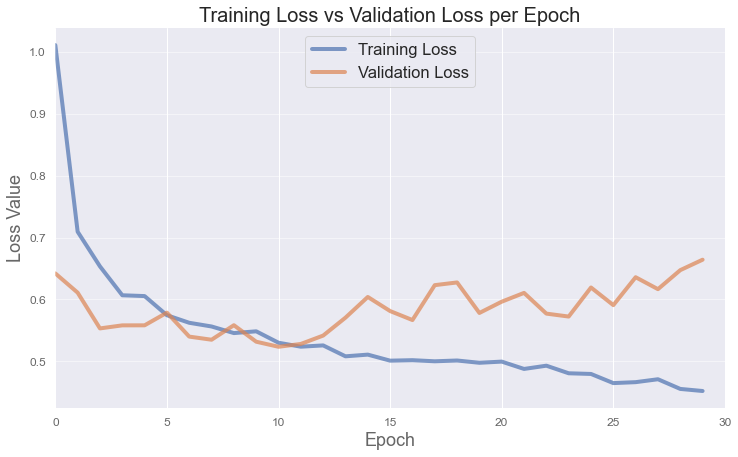

In [63]:

df = pd.DataFrame({'Training Loss':train_loss_history, 'Validation Loss':validation_loss_history})
df.plot(linewidth=4, alpha=0.7, figsize=(12,7), label='Loss')
plt.xlim([0,30])
# plt.ylim(-20,100)
plt.title('Training Loss vs Validation Loss per Epoch', fontsize=20)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Loss Value', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper center')
plt.show()


### Recall curves: Training Recall vs Validation Recall Per Epoch During Learning

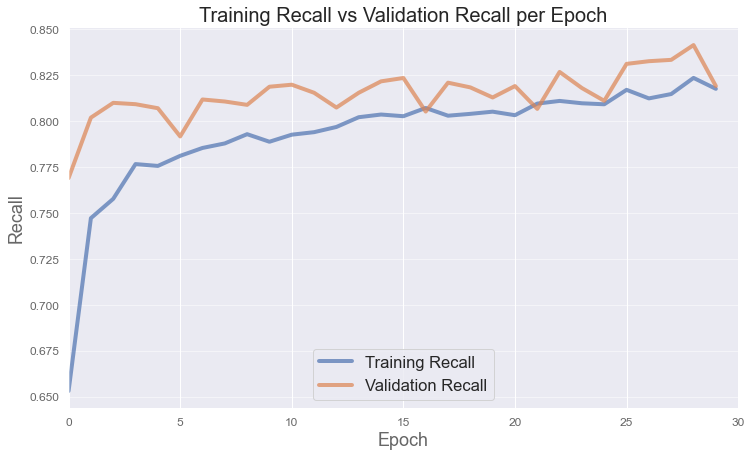

In [64]:

df = pd.DataFrame({'Training Recall':recall_train_history, 'Validation Recall':recall_validation_history})
df.plot(linewidth=4, alpha=0.7, figsize=(12,7), label='Loss')
plt.xlim([0,30])
# plt.ylim(-20,100)
plt.title('Training Recall vs Validation Recall per Epoch', fontsize=20)
plt.grid(axis='y', alpha=.5)
plt.yticks(fontsize=12, alpha=.7)
plt.xticks(fontsize=12, alpha=.7)
plt.xlabel('Epoch', fontsize=18, alpha=.7)
plt.ylabel('Recall', fontsize=18, alpha=.7)
# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='lower center')
plt.show()


## 2.e. Evaluate model

In [35]:
def _test_model(model):
    
    load_model(model, "BOW_Recall_0.8407014979905005.ckpt")  
    recall_test_history = list()

    model.eval()
    with torch.no_grad():
        y_true_val, y_pred_val= list(), list()

        for batch, targets, lengths in testloader:
            ## perform forward pass  
            batch = batch.type(torch.FloatTensor).to(set_device)
            pred = model(batch) 
            preds = torch.max(pred, 1)[1]

            ## accumulate predictions per batch for the epoch
            y_pred_val += list([x.item() for x in preds.detach().cpu().numpy()])
            targets = torch.LongTensor([x.item() for x in list(targets)])
            y_true_val +=  list([x.item() for x in targets.detach().cpu().numpy()])

            recall = evaluate_preds(y_true_val, y_pred_val)
            recall_test_history.append(recall)

        print(f'Testing => Recall score: {np.mean(recall_test_history)}')
        print(f'Classification Report =>\n {classification_report(y_true_val, y_pred_val)}')
        return recall_test_history


In [36]:
with warnings.catch_warnings(record=True):
    testloader = DataLoader(malware_testset, batch_size=32, shuffle=False)  
    model = MalwareNet(input_dim=train_data[0][0].shape[0], output_dim=len(label_encodings)).to(set_device)
    recall_test_history = _test_model(model)

Testing => Recall score: 0.8396123518636707
Classification Report =>
               precision    recall  f1-score   support

           0       0.95      0.84      0.89       899
           1       0.97      1.00      0.99       428
           2       0.70      0.49      0.58       294
           3       0.23      0.01      0.02       335
           4       1.00      1.00      1.00       345
           5       0.81      0.91      0.86      2585
           6       0.82      0.94      0.88      1563
           7       0.99      1.00      1.00       467
           8       0.77      0.75      0.76      2528
           9       0.85      0.90      0.88       556

    accuracy                           0.84     10000
   macro avg       0.81      0.78      0.78     10000
weighted avg       0.82      0.84      0.82     10000



## 2.f. Save Model + Data

In [30]:
dict = {f'{vectorization_method}_train_loss': train_loss_history, f'{vectorization_method}_val_loss': validation_loss_history, 
        f'{vectorization_method}_recall_train': recall_train_history, f'{vectorization_method}_recall_val': recall_validation_history}  
       
data= pd.DataFrame(dict) 
data.to_csv(f'{vectorization_method}_scores.csv')

test_scores = pd.DataFrame({f'{vectorization_method}_test_scores': recall_test_history})
test_scores.to_csv(f'{vectorization_method}_testscores.csv')

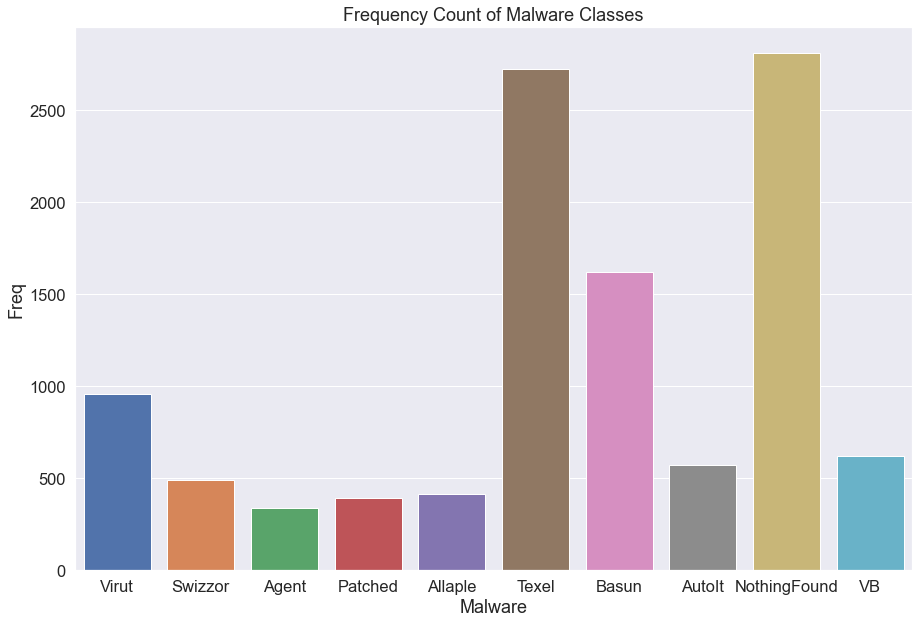

In [20]:
dff = pd.DataFrame()
dff['Freq'] = pd.Series(train_data[1]).value_counts().sort_index()
dff['Malware'] = ['Virut', 'Swizzor', 'Agent', 'Patched',  'Allaple', 'Texel',  'Basun',  'AutoIt',  'NothingFound', 'VB']
sns.set(rc={"figure.figsize":(15, 10)}, font_scale = 1.5)
ax = sns.barplot(x="Malware", y="Freq", data=dff, saturation=.9).set(title='Frequency Count of Malware Classes')

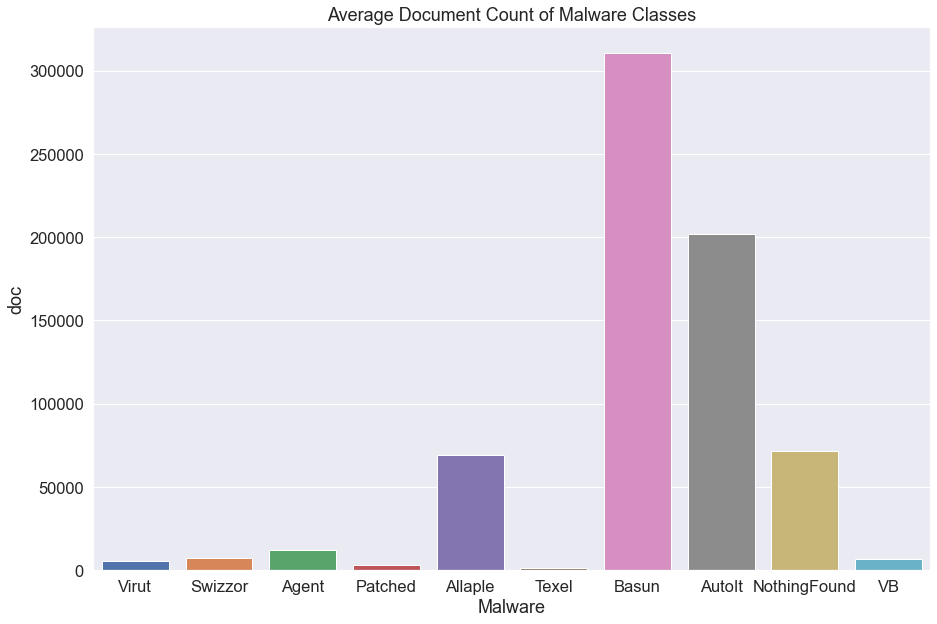

In [21]:
dd = pd.DataFrame([pd.Series(train_data[1]), pd.Series(train_data[2])]).T
dd.columns = ['malware_class', 'doc']
dd = dd.groupby(by='malware_class').mean()
dd['Malware']= ['Virut', 'Swizzor', 'Agent', 'Patched',  'Allaple', 'Texel',  'Basun',  'AutoIt',  'NothingFound', 'VB']
sns.set(rc={"figure.figsize":(15, 10)}, font_scale = 1.5)
ax = sns.barplot(x="Malware", y="doc", data=dd, saturation=.9).set(title='Average Document Count of Malware Classes')

---

# 3. Analysis

## 3.a. Summary: Main Results

Summarize your approach and results here

## 3.b. Discussion

Enter your final summary here.

For instance, you can address:
- What was the performance you obtained with the simplest approach?
- Which vectorized input representations helped more than the others?
- Which malwares are difficult to detect and why?
- Which approach do you recommend to perform malware classification?

<AxesSubplot:>

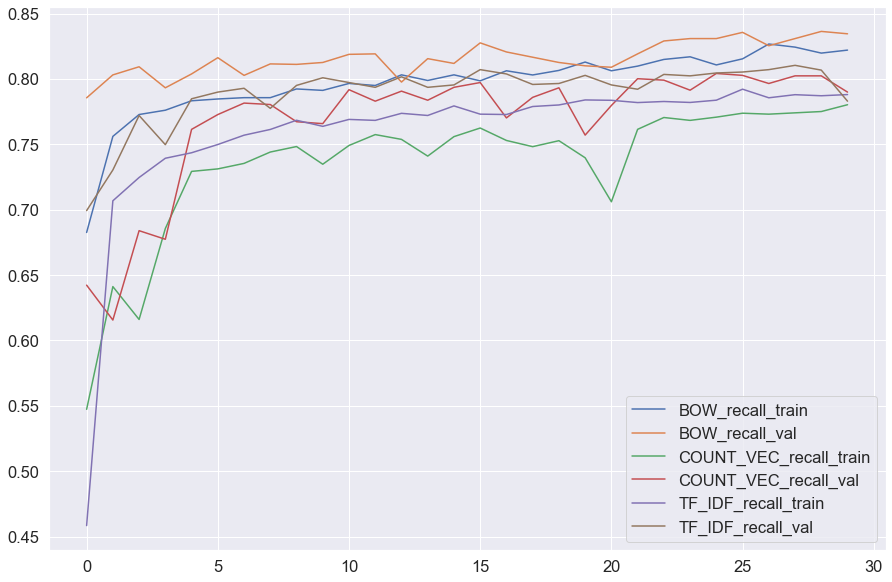

In [22]:
bow = pd.read_csv('BOW_scores.csv')
b1, b2 = bow['BOW_recall_train'],	bow['BOW_recall_val']
count_vec = pd.read_csv('COUNT_VEC_scores.csv')
c1, c2 = count_vec['COUNT_VEC_recall_train'],	count_vec['COUNT_VEC_recall_val']
tf_idf = pd.read_csv('TF_IDF_scores.csv')
t1, t2 = tf_idf['TF_IDF_recall_train'],	tf_idf['TF_IDF_recall_val']
df = pd.DataFrame({'BOW_recall_train':b1, 'BOW_recall_val':b2, 'COUNT_VEC_recall_train':c1, 'COUNT_VEC_recall_val':c2,
                  'TF_IDF_recall_train':t1,'TF_IDF_recall_val':t2})
df.plot()

<AxesSubplot:>

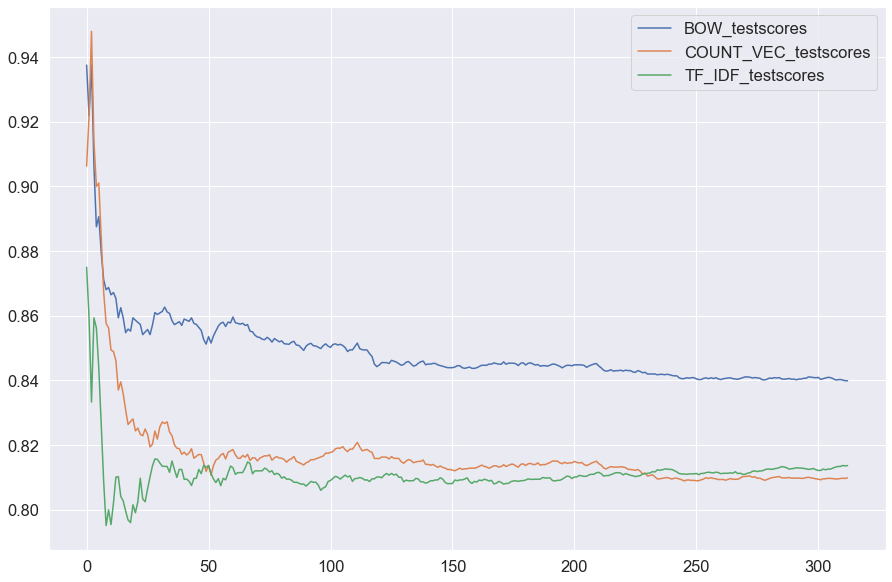

In [40]:
bow = pd.read_csv('BOW_testscores.csv')
b = bow['BOW_test_scores']
count_vec = pd.read_csv('COUNT_VEC_testscores.csv')
c = count_vec['COUNT_VEC_test_scores']
tf_idf = pd.read_csv('TF_IDF_testscores.csv')
t= tf_idf['TF_IDF_test_scores']
df = pd.DataFrame({'BOW_testscores':b, 'COUNT_VEC_testscores':c, 'TF_IDF_testscores':t})
df.plot()